In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sb

# Data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, recall_score, f1_score, confusion_matrix, precision_score

# Classification
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

## Load Data

In [2]:
df=pd.read_csv("train.csv")

## Exploratory Data Analysis

In [3]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103 entries, 0 to 1102
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1103 non-null   int64 
 1   Attrition                 1103 non-null   object
 2   BusinessTravel            1103 non-null   object
 3   DailyRate                 1103 non-null   int64 
 4   Department                1103 non-null   object
 5   DistanceFromHome          1103 non-null   int64 
 6   Education                 1103 non-null   int64 
 7   EducationField            1103 non-null   object
 8   EmployeeCount             1103 non-null   int64 
 9   EmployeeNumber            1103 non-null   int64 
 10  EnvironmentSatisfaction   1103 non-null   int64 
 11  Gender                    1103 non-null   object
 12  HourlyRate                1103 non-null   int64 
 13  JobInvolvement            1103 non-null   int64 
 14  JobLevel                

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

#### Check No, Yes(targets info) in train datset

In [4]:
df['Attrition'].value_counts()

No     931
Yes    172
Name: Attrition, dtype: int64

#### Classify Categorical Data & Numerical Data

In [5]:
# Finding Categorical data with integer values
print(df['Education'].unique())
print(df['EnvironmentSatisfaction'].unique())
print(df['JobInvolvement'].unique())
print(df['JobSatisfaction'].unique())
print(df['PerformanceRating'].unique())
print(df['RelationshipSatisfaction'].unique())
print(df['WorkLifeBalance'].unique())
print(df['NumCompaniesWorked'].unique())
print(df['JobLevel'].unique())
print(df['StockOptionLevel'].unique())

[3 2 1 5 4]
[3 2 4 1]
[2 3 1 4]
[2 3 1 4]
[4 3]
[3 4 1 2]
[3 1 2 4]
[1 2 4 3 6 0 8 5 7 9]
[1 2 3 4 5]
[1 0 2 3]


In order to see data conveniently change type of Categorical data to string(object)

In [6]:
cat_cols = ['Education','EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','PerformanceRating',
            'RelationshipSatisfaction','WorkLifeBalance','NumCompaniesWorked','JobLevel','StockOptionLevel']

# int->str(ohject)
df[cat_cols] = df[cat_cols].astype(str)

#### Categorical data visualization

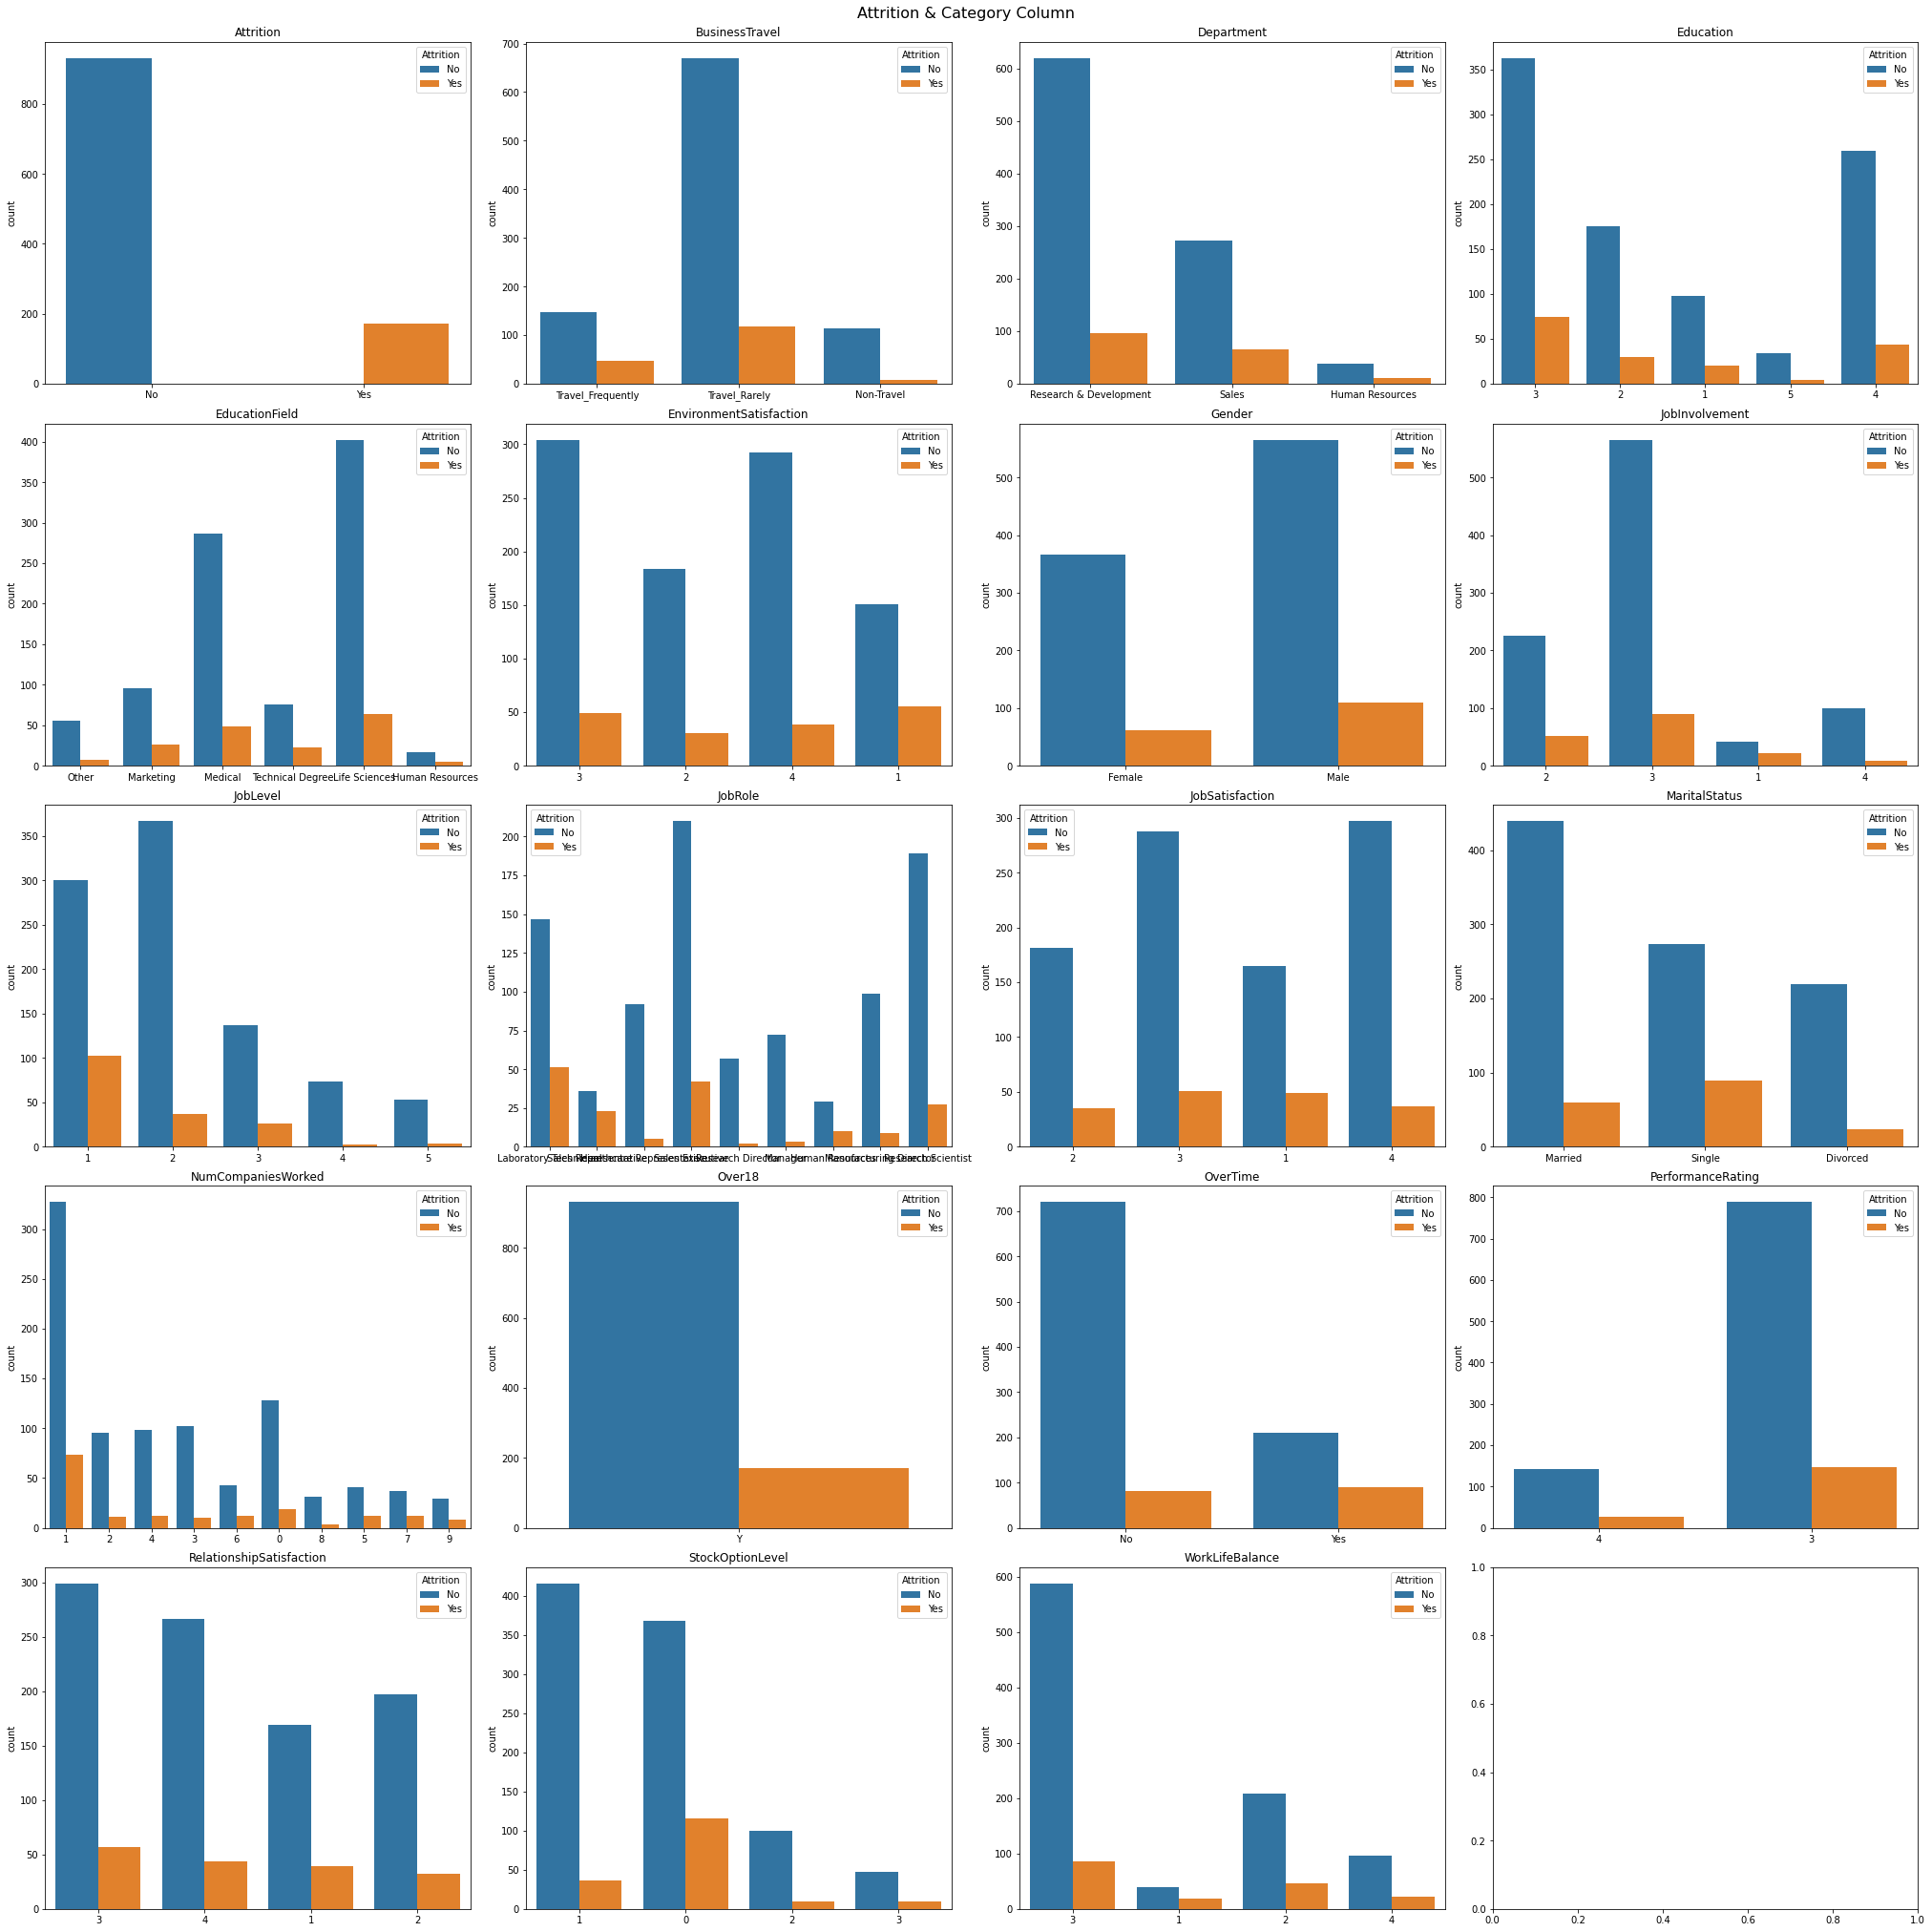

In [7]:
categorical = [column for column in df.columns if df[column].dtype == object]

fig, ax = plt.subplots(5, 4, figsize=(28, 28), constrained_layout=True)
ax = ax.flatten()
fig.suptitle('Attrition & Category Column', fontsize=16)

for i in range(len(categorical)):
    sb.countplot(x=categorical[i], data=df,hue='Attrition', ax=ax[i]).set(xlabel = None)
    ax[i].set(title = categorical[i])
    
plt.show()

"Over18" column has only one value for every instance.

#### Numerical data visualization

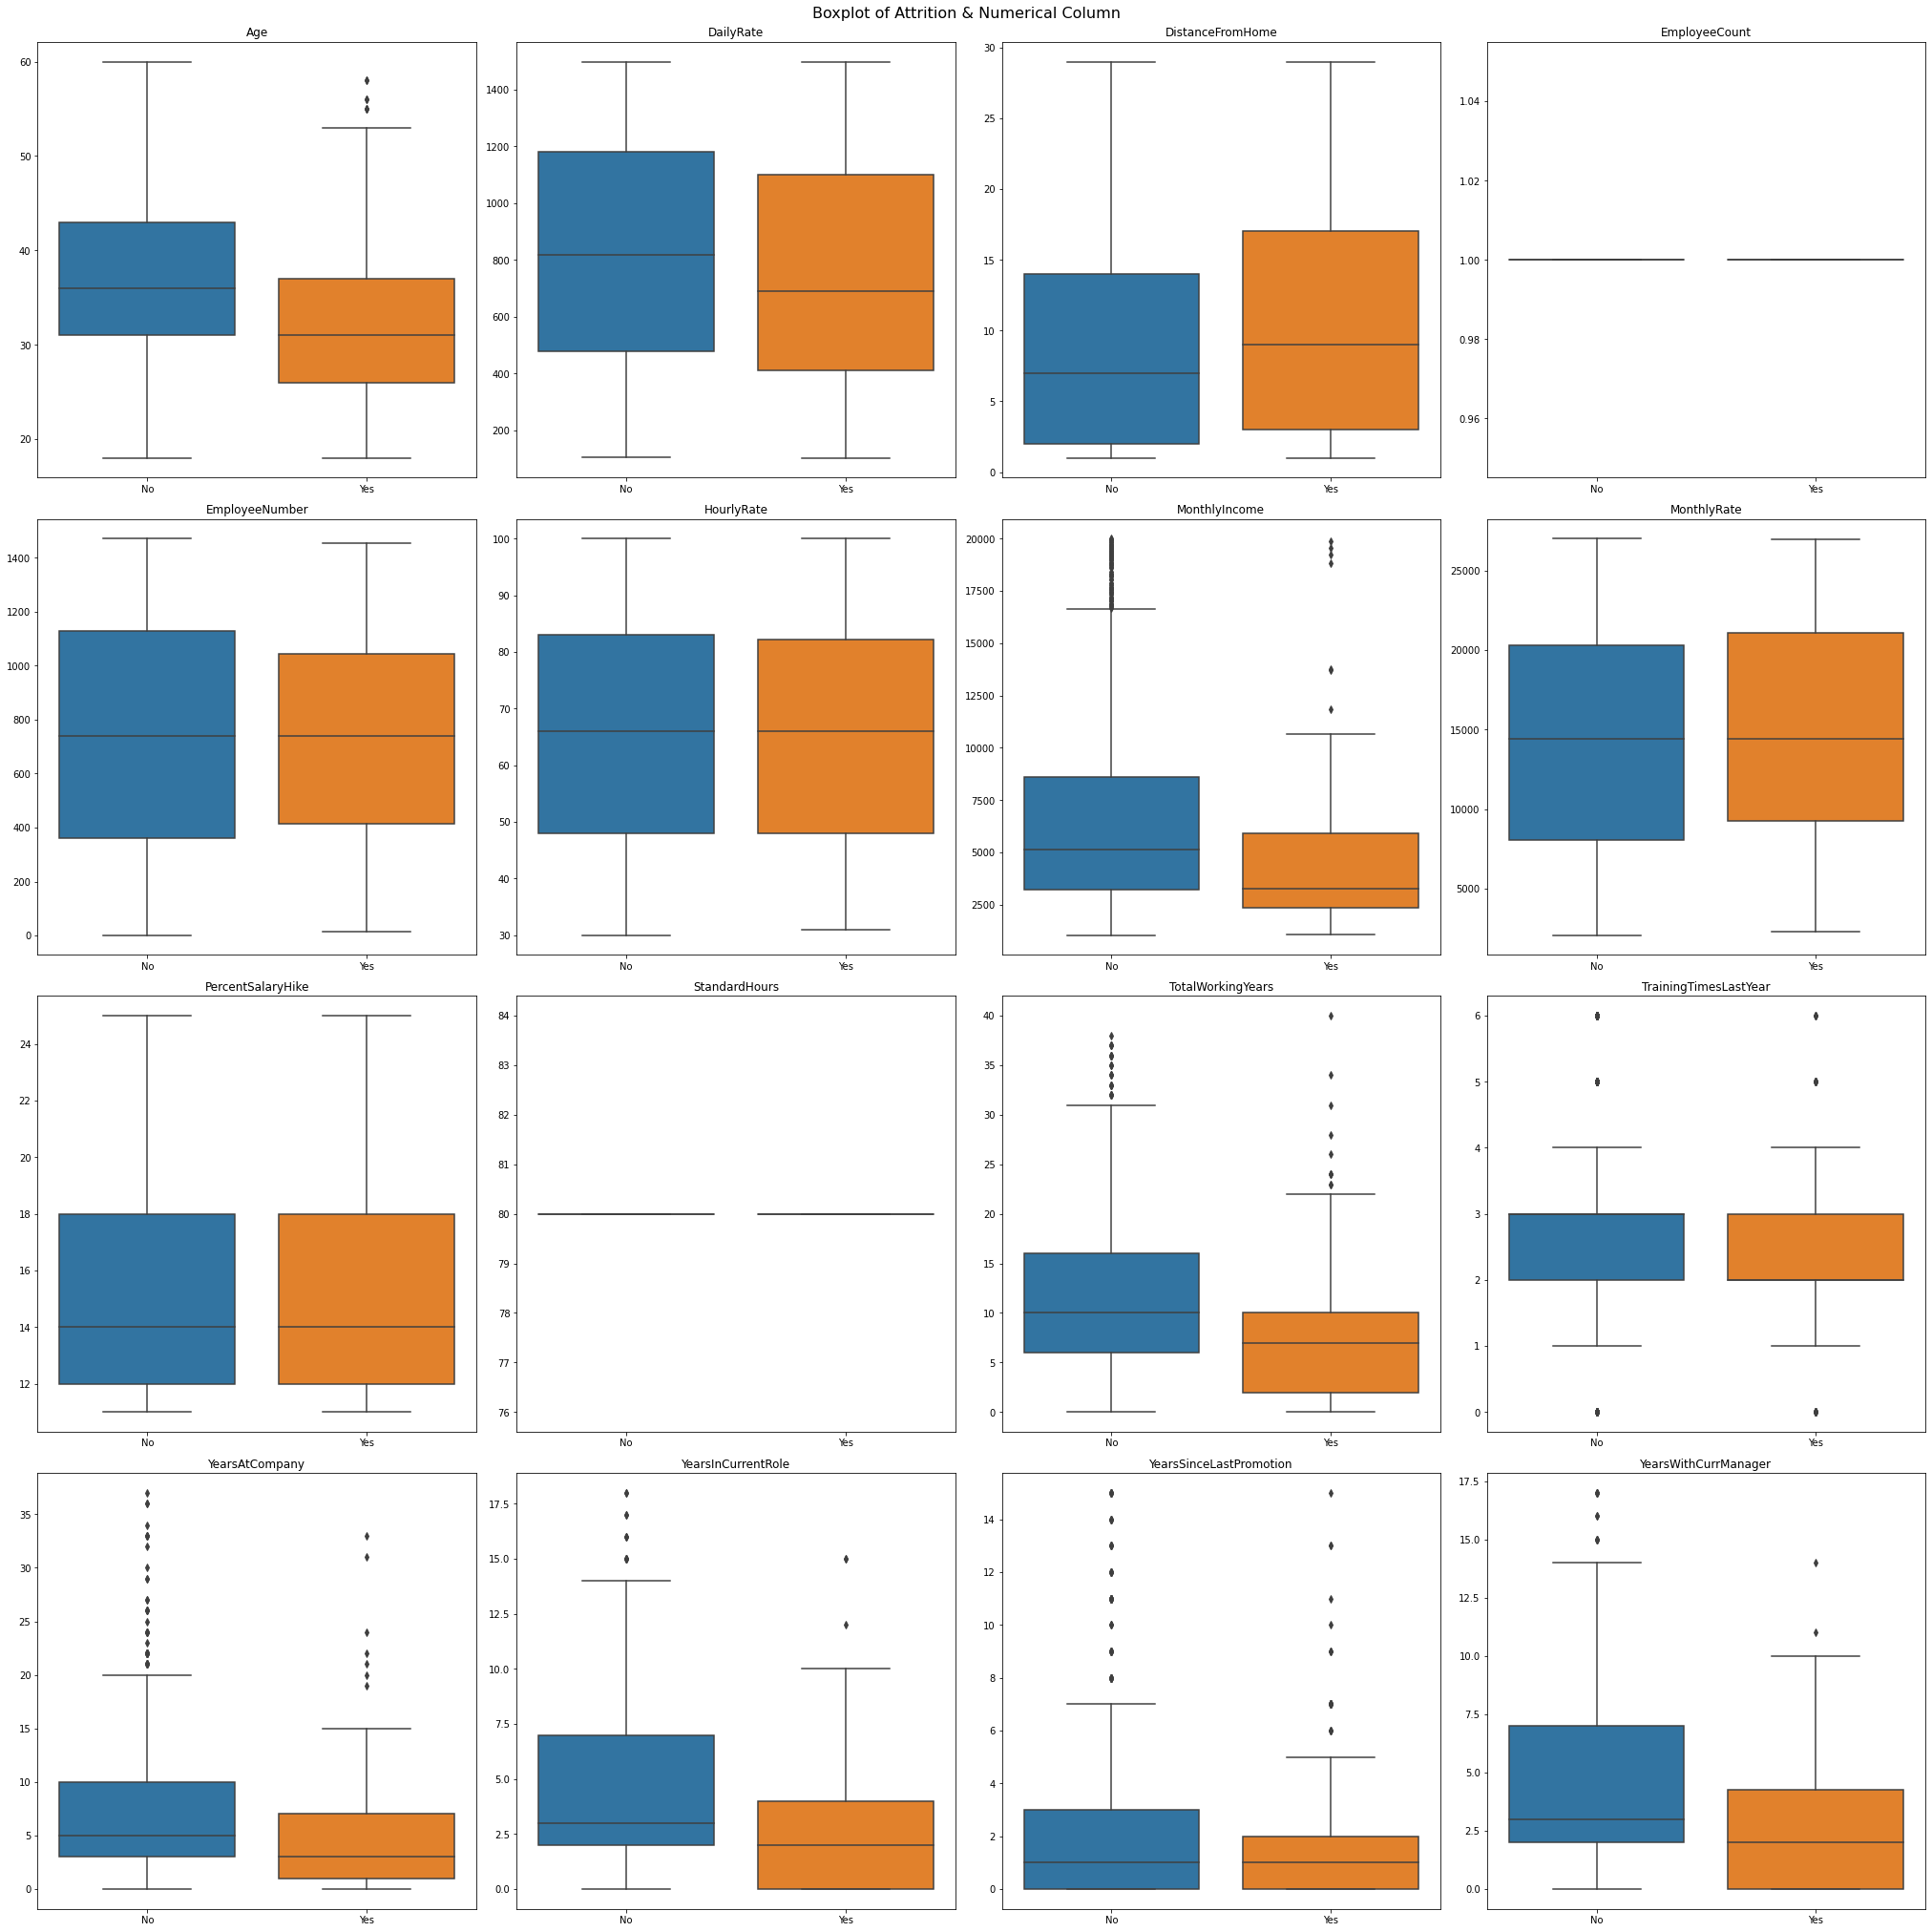

In [8]:
numeric = [column for column in df.columns if df[column].dtype != object]

# boxplot
fig, ax = plt.subplots(4, 4, figsize=(28, 28), constrained_layout=True)
ax = ax.flatten()
fig.suptitle('Boxplot of Attrition & Numerical Column', fontsize=16)

for i in range(len(numeric)):
    ax[i].set(title = numeric[i])
    sb.boxplot(x=df['Attrition'], y = df[numeric[i]], ax=ax[i]).set(xlabel=None,  ylabel=None)
    
plt.show()

Every instance has same value of "StandardHours", and "EmployeeCount" respectively. EmployeeNumber is the unique value for each instance.

There are some outliers.

## Data Preprocessing

Missing data have been checked above and there is no missing data in the training dataset.

#### Drop Necessary Columns

In [9]:
df.drop(['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'], axis = 1, inplace = True)

#### Outliers Check

In [10]:
def outlier(data, col):
    q1 = np.percentile(df[col], 25) 
    q3 = np.percentile(df[col], 75)
    IQR = q3 - q1
    outlier_step = 1.5 * IQR
    return df[(df[col] < q1 - outlier_step) | (df[col] > q3 + outlier_step)]

In [11]:
monthlyincom_outlier = outlier(df, 'MonthlyIncome')
print("------------------MonthlyIncome------------------")
print(f'Outliers of MonthlyIncome : {monthlyincom_outlier.shape[0]}')
print(f'{round(monthlyincom_outlier.shape[0] / df.shape[0],2)}% of the whole data')
print(monthlyincom_outlier.Attrition.value_counts())

print()
workingyear_outlier = outlier(df, 'TotalWorkingYears')
print("------------------TotalWorkingYears------------------")
print(f'Outliers of TotalWorkingYears : {workingyear_outlier.shape[0]}')
print(f'{round(workingyear_outlier.shape[0] / df.shape[0],2)}% of the whole data')
print(workingyear_outlier.Attrition.value_counts())

print()
trainingtime_outlier = outlier(df, 'TrainingTimesLastYear')
print("------------------TrainingTimesLastYear------------------")
print(f'Outliers of TrainingTimesLastYear : {trainingtime_outlier.shape[0]}')
print(f'{round(trainingtime_outlier.shape[0] / df.shape[0],2)}% of the whole data')
print(trainingtime_outlier.Attrition.value_counts())

print()
yearsatcomp_outlier = outlier(df, 'YearsAtCompany')
print("------------------YearsAtCompany------------------")
print(f'Outliers of YearsAtCompany : {yearsatcomp_outlier.shape[0]}')
print(f'{round(yearsatcomp_outlier.shape[0] / df.shape[0],2)}% of the whole data')
print(yearsatcomp_outlier.Attrition.value_counts())

print()
yearsinrole_outlier = outlier(df, 'YearsInCurrentRole')
print("------------------YearsAtCompany------------------")
print(f'Outliers of YearsAtCompany : {yearsinrole_outlier.shape[0]}')
print(f'{round(yearsinrole_outlier.shape[0] / df.shape[0],2)}% of the whole data')
print(yearsinrole_outlier.Attrition.value_counts())

print()
yearspromo_outlier = outlier(df, 'YearsSinceLastPromotion')
print("------------------YearsAtCompany------------------")
print(f'Outliers of YearsAtCompany : {yearspromo_outlier.shape[0]}')
print(f'{round(yearspromo_outlier.shape[0] / df.shape[0],2)}% of the whole data')
print(yearspromo_outlier.Attrition.value_counts())

print()
yearswithmanag_outlier = outlier(df, 'YearsWithCurrManager')
print("------------------YearsAtCompany------------------")
print(f'Outliers of YearsAtCompany : {yearswithmanag_outlier.shape[0]}')
print(f'{round(yearswithmanag_outlier.shape[0] / df.shape[0],2)}% of the whole data')
print(yearswithmanag_outlier.Attrition.value_counts())


------------------MonthlyIncome------------------
Outliers of MonthlyIncome : 100
0.09% of the whole data
No     96
Yes     4
Name: Attrition, dtype: int64

------------------TotalWorkingYears------------------
Outliers of TotalWorkingYears : 49
0.04% of the whole data
No     46
Yes     3
Name: Attrition, dtype: int64

------------------TrainingTimesLastYear------------------
Outliers of TrainingTimesLastYear : 182
0.17% of the whole data
No     155
Yes     27
Name: Attrition, dtype: int64

------------------YearsAtCompany------------------
Outliers of YearsAtCompany : 50
0.05% of the whole data
No     45
Yes     5
Name: Attrition, dtype: int64

------------------YearsAtCompany------------------
Outliers of YearsAtCompany : 15
0.01% of the whole data
No     13
Yes     2
Name: Attrition, dtype: int64

------------------YearsAtCompany------------------
Outliers of YearsAtCompany : 156
0.14% of the whole data
No     132
Yes     24
Name: Attrition, dtype: int64

------------------YearsAtCo

There are columns('TrainingTimesLastYear','YearsAtCompany') with many outliers. In order to deal with these outliers Robustscaler() will be applied. It is because outliers may be anomalies that are essential to capture information about topics of interest 

#### Data transformation

In [12]:
numeric_features = [column for column in df.columns if df[column].dtype != object]
categorical_features = [column for column in df.columns if df[column].dtype == object]

# apply LabelEncoder so machine can read categorical data
df[categorical_features] = df[categorical_features].apply(LabelEncoder().fit_transform)
# apply RobustScaler to deal with outliers
df[numeric_features] = RobustScaler().fit_transform(df[numeric_features])

#### Get data to train classifier

In [13]:
X = df.drop(labels= ['Attrition'], axis = 1)
y_train = df.Attrition

In [14]:
scaler = MinMaxScaler()
scaler.fit(X)
X_train= scaler.transform(X)

In [15]:
# in order to use them to find the best performing model
X_check=X_train
y_check=y_train

## Finding the Best Model

### In order to compare three models, train dataset(train.csv) is splitted into train and test set

Model score checking method

In [16]:
def model_score(y_test, predict):
    print('Accuracy : ',round(accuracy_score(y_test, predict), 3))
    print('Recall : ',round(recall_score(y_test, predict), 3))
    print('Precision : ',round(precision_score(y_test, predict), 3))
    print('F1_Score : ',round(f1_score(y_test, predict), 3))
    print()
    print('Confusion_matrix :')
    print(confusion_matrix(y_test, predict))

In [17]:
trainX, testX, trainY, testY = train_test_split(X_check, y_check, test_size = 0.2, random_state = 0)

In [18]:
print("---------Start training Gradient Boosting Classifier---------")    
gbc = GradientBoostingClassifier(n_estimators=800,random_state=0)
gbc.fit(trainX, trainY)
predict_gb = gbc.predict(testX)
model_score(testY, predict_gb)

---------Start training Gradient Boosting Classifier---------
Accuracy :  0.896
Recall :  0.444
Precision :  0.6
F1_Score :  0.511

Confusion_matrix :
[[186   8]
 [ 15  12]]


In [19]:
print("---------Start training XGBoosting Classifier---------")
xgb=XGBClassifier(n_estimators = 500,random_state=0)
xgb.fit(trainX, trainY)
predict_xgb = xgb.predict(testX)
model_score(testY, predict_xgb)

---------Start training XGBoosting Classifier---------
Accuracy :  0.873
Recall :  0.222
Precision :  0.462
F1_Score :  0.3

Confusion_matrix :
[[187   7]
 [ 21   6]]


In [20]:
print("---------Start training Logistic Regression---------")
lr = LogisticRegression()
lr.fit(trainX, trainY)
predict_lr = lr.predict(testX)
model_score(testY, predict_lr)

---------Start training Logistic Regression---------
Accuracy :  0.882
Recall :  0.222
Precision :  0.545
F1_Score :  0.316

Confusion_matrix :
[[189   5]
 [ 21   6]]


##### Gradient Boosting model's performance is the best among three models
#### Final Model : Gradient Boosting Classifier

## Final Data Pre-processing based on Gradient Boosting Classifier

In [21]:
print("---------Boosting---------")    
gbc = GradientBoostingClassifier(n_estimators=800,random_state=0)
gbc.fit(X_train, y_train)

---------Boosting---------


GradientBoostingClassifier(n_estimators=800, random_state=0)

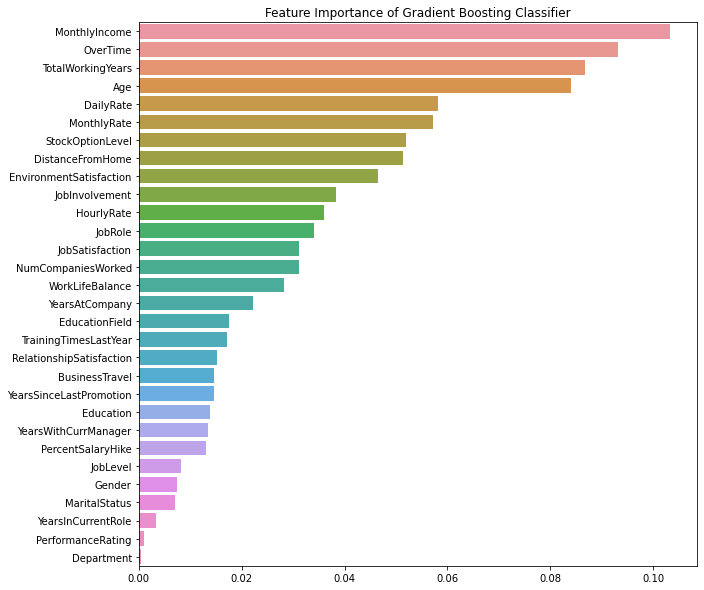

In [22]:
importance_values = gbc.feature_importances_

series = pd.Series(importance_values, index = X.columns)
feature_imp = series.sort_values(ascending=False)[:]

# Vistualization
plt.figure(figsize=(10,10))
plt.title('Feature Importance of Gradient Boosting Classifier')
sb.barplot(x=feature_imp, y=feature_imp.index)
plt.show()

## Final Step of Building Model Based on the Results Above

#### Get data for traning Gradient Boosting Classifier

In [23]:
#load data
df=pd.read_csv("train.csv")

#change type of categorical data int->obj
df[cat_cols] = df[cat_cols].astype(str)

#Dropping columns
df.drop(['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'], axis = 1, inplace = True)
df.drop(['Department','PerformanceRating','YearsInCurrentRole'], axis = 1, inplace = True)

numeric_features = [column for column in df.columns if df[column].dtype != object]
categorical_features = [column for column in df.columns if df[column].dtype == object]

df[categorical_features] = df[categorical_features].apply(LabelEncoder().fit_transform)
df[numeric_features] = RobustScaler().fit_transform(df[numeric_features])

#Data for training model
X = df.drop(labels= ['Attrition'], axis = 1)
y_train = df.Attrition

scaler = MinMaxScaler()
scaler.fit(X)
X_train= scaler.transform(X)

#### Train Gradient Boosting

In [24]:
print("---------Start training Gradient Boosting Classifier---------")    
gbc = GradientBoostingClassifier(n_estimators=800,random_state=0)
gbc.fit(X_train,y_train)

---------Start training Gradient Boosting Classifier---------


GradientBoostingClassifier(n_estimators=800, random_state=0)

## Predict Employee Attrition

In [25]:
def getTestset():
    df_test = pd.read_csv("test.csv")
    cat_cols = ['Education','EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','PerformanceRating',
            'RelationshipSatisfaction','WorkLifeBalance','NumCompaniesWorked','JobLevel','StockOptionLevel']
    df_test[cat_cols] = df_test[cat_cols].astype(str)
    df_test.drop(['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'], axis = 1, inplace = True)
    df_test.drop(['Department','PerformanceRating','YearsInCurrentRole'], axis = 1, inplace = True)

    numeric_features = [column for column in df_test.columns if df_test[column].dtype != object]
    categorical_features = [column for column in df_test.columns if df_test[column].dtype == object]
 
    df_test[categorical_features] = df_test[categorical_features].apply(LabelEncoder().fit_transform)
    df_test[numeric_features] = RobustScaler().fit_transform(df_test[numeric_features])
 
    df_test=df_test.drop(labels=['Attrition'], axis = 1)
    scaler = MinMaxScaler()
    scaler.fit(df_test)
    X_t = scaler.transform(df_test)
    return X_t

def test_result(Model, X):
    pre=Model.predict(X)
    result=pd.DataFrame(pre)
    result=result.rename(columns = {0:'Attrition'})
    df_Test = pd.read_csv("test.csv")
    df_Test =df_Test.drop(labels=['Attrition'], axis = 1)
    predict_result = pd.concat([df_Test, result], axis=1)
    save = predict_result[["EmployeeNumber","Attrition"]]
    save['Attrition']=save['Attrition'].replace({0:'No', 1:'Yes'})
    return save

#Checking how many yes in dataset
def Yes_check(df):
    final=df[df["Attrition"]=='Yes']
    print("Number of Employees may leave the company : ", final.shape[0])
    return final[["Attrition","EmployeeNumber"]]

In [26]:
test_X = getTestset()
result=test_result(gbc, test_X)
result.to_csv("submission.csv", mode='w',index=False)

In [27]:
Yes_check(result)

Number of Employees may leave the company :  34


,Attrition,EmployeeNumber
10,Yes,37
31,Yes,103
34,Yes,123
35,Yes,127
56,Yes,215
60,Yes,235
90,Yes,358
95,Yes,386
109,Yes,440
115,Yes,466
